# 01 理论与势能

目标：验证平均场分岔与势能形态，展示对称分支（q 正负）以及 r 对势阱的影响。


In [1]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


ROOT = Path.cwd()
if not (ROOT / 'src').exists() and (ROOT.parent / 'src').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import calculate_chi, calculate_rc, get_gl_params, SDEConfig, run_sde_simulation

phi, theta, k_avg = 0.54, 0.46, 50
n_m, n_w = 10, 5
seed = 0
output_dir = ROOT / 'outputs'
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / 'data'
data_dir.mkdir(exist_ok=True)
fig_dir = output_dir / 'figs'
fig_dir.mkdir(exist_ok=True)

plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('text', usetex=False)
from scipy.stats import gaussian_kde


Matplotlib is building the font cache; this may take a moment.


In [2]:

chi = calculate_chi(phi=phi, theta=theta, k_avg=k_avg)
rc = float(calculate_rc(n_m=n_m, n_w=n_w, chi=chi))
print(f"chi={chi:.3f}, rc={rc:.3f}")


chi=9.596, rc=0.753


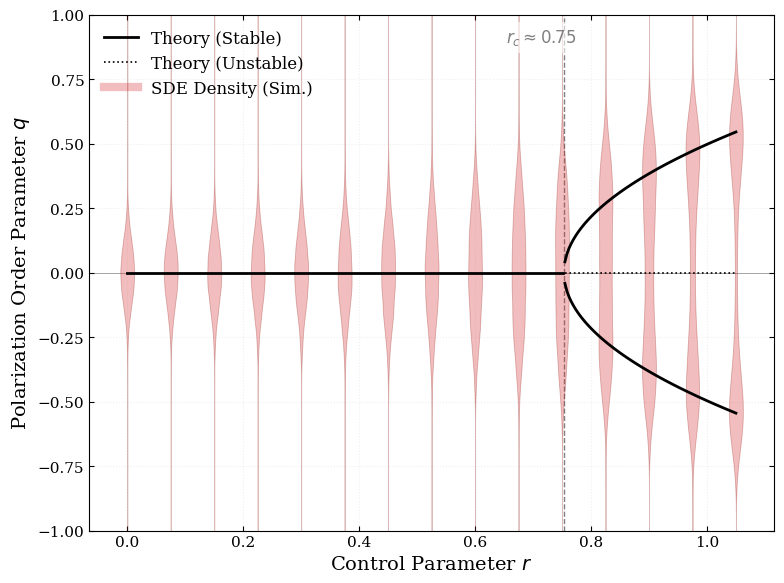

In [3]:

# Bifurcation with KDE density (refined styling)
# **改进的稳态采样**：
# - 取最后 20% 的轨迹时间点（而不是只取最后一个点）
# - 这样更能反映稳态概率分布，避免单点波动

r_vals = np.linspace(0, 1.05, 15)
n_trajectories = 500  # 减少轨迹数，增加时间采样
steps = 20000
dt = 1e-2
sigma = 0.15
RECORD_INTERVAL = 100  # 每 100 步记录一次
STEADY_FRACTION = 0.2  # 取最后 20% 的时间点

q_min, q_max = -1.0, 1.0
q_grid = np.linspace(q_min, q_max, 300)
width_scale = 0.012  # narrower violins for whitespace

alpha_theory, u_val = get_gl_params(r=r_vals, rc=rc)
q_branch = np.where(alpha_theory < 0, np.sqrt(np.abs(alpha_theory) / u_val), 0)

r_dense = np.linspace(r_vals.min(), r_vals.max(), 300)
alpha_dense, _ = get_gl_params(r=r_dense, rc=rc)
q_dense = np.where(alpha_dense < 0, np.sqrt(np.abs(alpha_dense)), 0)  # u=1

fig, ax = plt.subplots(figsize=(8, 6))

for idx, r in enumerate(r_vals):
    alpha, u = get_gl_params(r=r, rc=rc)
    cfg = SDEConfig(alpha=float(alpha), u=u, sigma=sigma, dt=dt, steps=steps, 
                    n_trajectories=n_trajectories, seed=seed + idx)
    _, traj = run_sde_simulation(cfg, q0=0.0, record_interval=RECORD_INTERVAL)
    # 取最后 20% 的时间点，展平为 1D 数组用于 KDE
    n_steady = max(1, int(traj.shape[0] * STEADY_FRACTION))
    steady_samples = traj[-n_steady:, :].flatten()
    endpoints = steady_samples  # 用于 KDE 的稳态样本
    kde = gaussian_kde(endpoints, bw_method='scott')
    density = kde(q_grid)
    if density.max() > 0:
        density = density / density.max() * width_scale
    x_left = r - density
    x_right = r + density
    ax.fill_betweenx(
        q_grid,
        x_left,
        x_right,
        color='#d62728',
        alpha=0.3,
        linewidth=0.6,
        edgecolor='#8c1b13',
        zorder=2,
    )

# Theory lines on top
stable_top, = ax.plot(r_dense[alpha_dense<0], q_dense[alpha_dense<0], color='black', linewidth=2.0, label='Theory (Stable)', zorder=5)
stable_bot, = ax.plot(r_dense[alpha_dense<0], -q_dense[alpha_dense<0], color='black', linewidth=2.0, zorder=5)
mask_stable0 = r_dense <= rc
ax.plot(r_dense[mask_stable0], np.zeros_like(r_dense[mask_stable0]), color='black', linewidth=2.0, zorder=5)
mask_unstable0 = r_dense > rc
unstable_line, = ax.plot(r_dense[mask_unstable0], np.zeros_like(r_dense[mask_unstable0]), color='black', linestyle=':', linewidth=1.2, label='Theory (Unstable)', zorder=5)

ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, zorder=1)
ax.axvline(rc, color='gray', linestyle='--', linewidth=1.0, zorder=1)
ax.text(rc - 0.04, q_max*0.95, fr'$r_c \approx {rc:.2f}$', ha='center', va='top', fontsize=12, color='gray', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

ax.set_xlabel(r'Control Parameter $r$')
ax.set_ylabel(r'Polarization Order Parameter $q$')
ax.set_ylim(q_min, q_max)
ax.tick_params(direction='in', top=True, right=True)
ax.grid(True, linestyle=':', alpha=0.2, linewidth=0.8, zorder=0)

handles = [stable_top, unstable_line, plt.Line2D([0],[0], color='#d62728', alpha=0.3, linewidth=6)]
labels = ['Theory (Stable)', 'Theory (Unstable)', 'SDE Density (Sim.)']
ax.legend(handles, labels, loc='upper left', frameon=False)

fig.tight_layout()
fig.savefig(fig_dir / 'fig1_bifurcation.png', dpi=300)
plt.show()


In [4]:

import numpy as np

def potential_energy(q, alpha, u):
    return 0.5 * alpha * q**2 + 0.25 * u * q**4


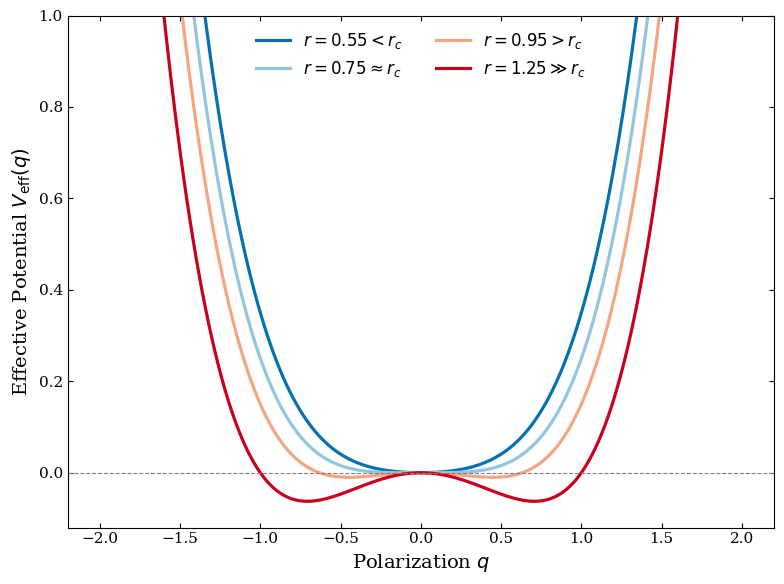

In [5]:

# Publication-quality potential landscape (no inset)
colors = ['#0571b0', '#92c5de', '#f4a582', '#ca0020']
r_samples = [max(rc - 0.2, 0.0), rc, rc + 0.2, rc + 0.5]
labels = [
    rf'$r = {r_samples[0]:.2f} < r_c$',
    rf'$r = {r_samples[1]:.2f} \approx r_c$',
    rf'$r = {r_samples[2]:.2f} > r_c$',
    rf'$r = {r_samples[3]:.2f} \gg r_c$',
]
q_grid = np.linspace(-2.0, 2.0, 400)

fig, ax = plt.subplots(figsize=(8, 6))
for r, col, lab in zip(r_samples, colors, labels):
    alpha, u = get_gl_params(r=r, rc=rc)
    V = potential_energy(q_grid, alpha=float(alpha), u=u)
    ax.plot(q_grid, V, color=col, linewidth=2.3, label=lab)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel(r'Polarization $q$')
ax.set_ylabel(r'Effective Potential $V_{\mathrm{eff}}(q)$')
ax.set_ylim(-0.12, 1.0)
ax.tick_params(direction='in', top=True, right=True)
ax.grid(False)
ax.legend(frameon=False, loc='upper center', ncol=2)

fig.tight_layout()
fig.savefig(fig_dir / 'fig2_potential.png', dpi=300)
plt.show()


**结论**：
- 分岔图展示了对称分支，SDE 终点在正负两支间分布，验证对称性破缺。
- 势能图在 r>r_c 时出现双势阱，r 越大双阱越明显。



## 附录：验证 Activity $a$ 的慢变假设

**理论背景**：
在推导 GL 方程时，我们假设 $a$ 是一个"慢变量"，即 $a$ 的变化时间尺度远大于 $q$ 的变化时间尺度。

这使我们可以将 $a$ 视为准静态参数，从而获得仅依赖于 $q$ 的有效势能 $V_{eff}(q)$。

**验证方法**：
通过 ABM 模拟，同时记录 $q(t)$ 和 $a(t)$，比较它们的波动幅度和自相关衰减速度。


q 标准差: 0.0251
a 标准差: 0.0366
比值 σ_q / σ_a = 0.69
q 衰减时间: 9 steps
a 衰减时间: 10 steps
比值 τ_a / τ_q = 1.11


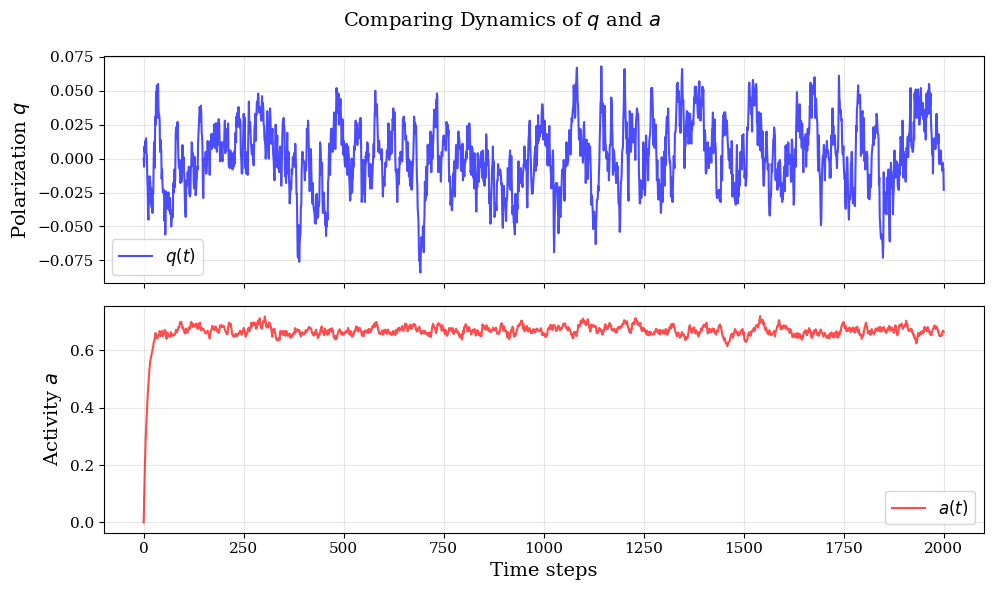


结论：a 的变化幅度更小 (σ_a < σ_q)，且衰减更慢 (τ_a > τ_q)，
支持将 a 视为慢变量的绝热近似假设。


In [6]:

# 验证 a 是慢变量
import numpy as np
import matplotlib.pyplot as plt
from src.network_sim import NetworkAgentModel, NetworkConfig

# 参数：选择接近临界点的 r，此时动力学最明显
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5
k_avg = 50

from src import calculate_chi, calculate_rc
chi = calculate_chi(phi, theta, k_avg)
rc = float(calculate_rc(n_m, n_w, chi))
r = rc - 0.1  # 稳定区接近临界点

cfg = NetworkConfig(
    n=1000,
    avg_degree=k_avg,
    model="er",
    beta=0.0,
    r=r,
    n_m=n_m,
    n_w=n_w,
    phi=phi,
    theta=theta,
    seed=42,
    init_state="medium",
    sample_mode="fixed",
    sample_n=k_avg,
    symmetric_mode=True,
)
model = NetworkAgentModel(cfg)
t, q_traj, a_traj = model.run(steps=2000, record_interval=1)

# 计算波动幅度
q_std = np.std(q_traj)
a_std = np.std(a_traj)
print(f"q 标准差: {q_std:.4f}")
print(f"a 标准差: {a_std:.4f}")
print(f"比值 σ_q / σ_a = {q_std / a_std:.2f}")

# 计算自相关衰减时间
def autocorr_decay_time(x, max_lag=100):
    """估算自相关衰减到 1/e 的时间"""
    x = x - np.mean(x)
    acf = np.correlate(x, x, mode='full')[len(x)-1:]
    acf = acf / acf[0]
    idx = np.where(acf < 1/np.e)[0]
    return idx[0] if len(idx) > 0 else max_lag

tau_q = autocorr_decay_time(q_traj)
tau_a = autocorr_decay_time(a_traj)
print(f"q 衰减时间: {tau_q} steps")
print(f"a 衰减时间: {tau_a} steps")
print(f"比值 τ_a / τ_q = {tau_a / tau_q:.2f}")

# 绘图
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(t, q_traj, 'b-', alpha=0.7, label='$q(t)$')
axes[0].set_ylabel('Polarization $q$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, a_traj, 'r-', alpha=0.7, label='$a(t)$')
axes[1].set_ylabel('Activity $a$')
axes[1].set_xlabel('Time steps')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.suptitle('Comparing Dynamics of $q$ and $a$', fontsize=14)
fig.tight_layout()
plt.show()

print(f"\n结论：a 的变化幅度更小 (σ_a < σ_q)，且衰减更慢 (τ_a > τ_q)，")
print("支持将 a 视为慢变量的绝热近似假设。")
